In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D,Input
from keras.models import Sequential,Model
from keras.preprocessing import image
from keras.src.legacy.preprocessing.image import ImageDataGenerator

## pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Evalution metrics
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_path = r"C:\Users\Afrin\Downloads\vegetable dataset\train"
test_path = r"C:\Users\Afrin\Downloads\vegetable dataset\test"
val_path = r"C:\Users\Afrin\Downloads\vegetable dataset\validation"

In [3]:
# extracting the different categories present in train dataset to plot 

image_categories = os.listdir( r"C:\Users\Afrin\Downloads\vegetable dataset\train")

print(image_categories)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


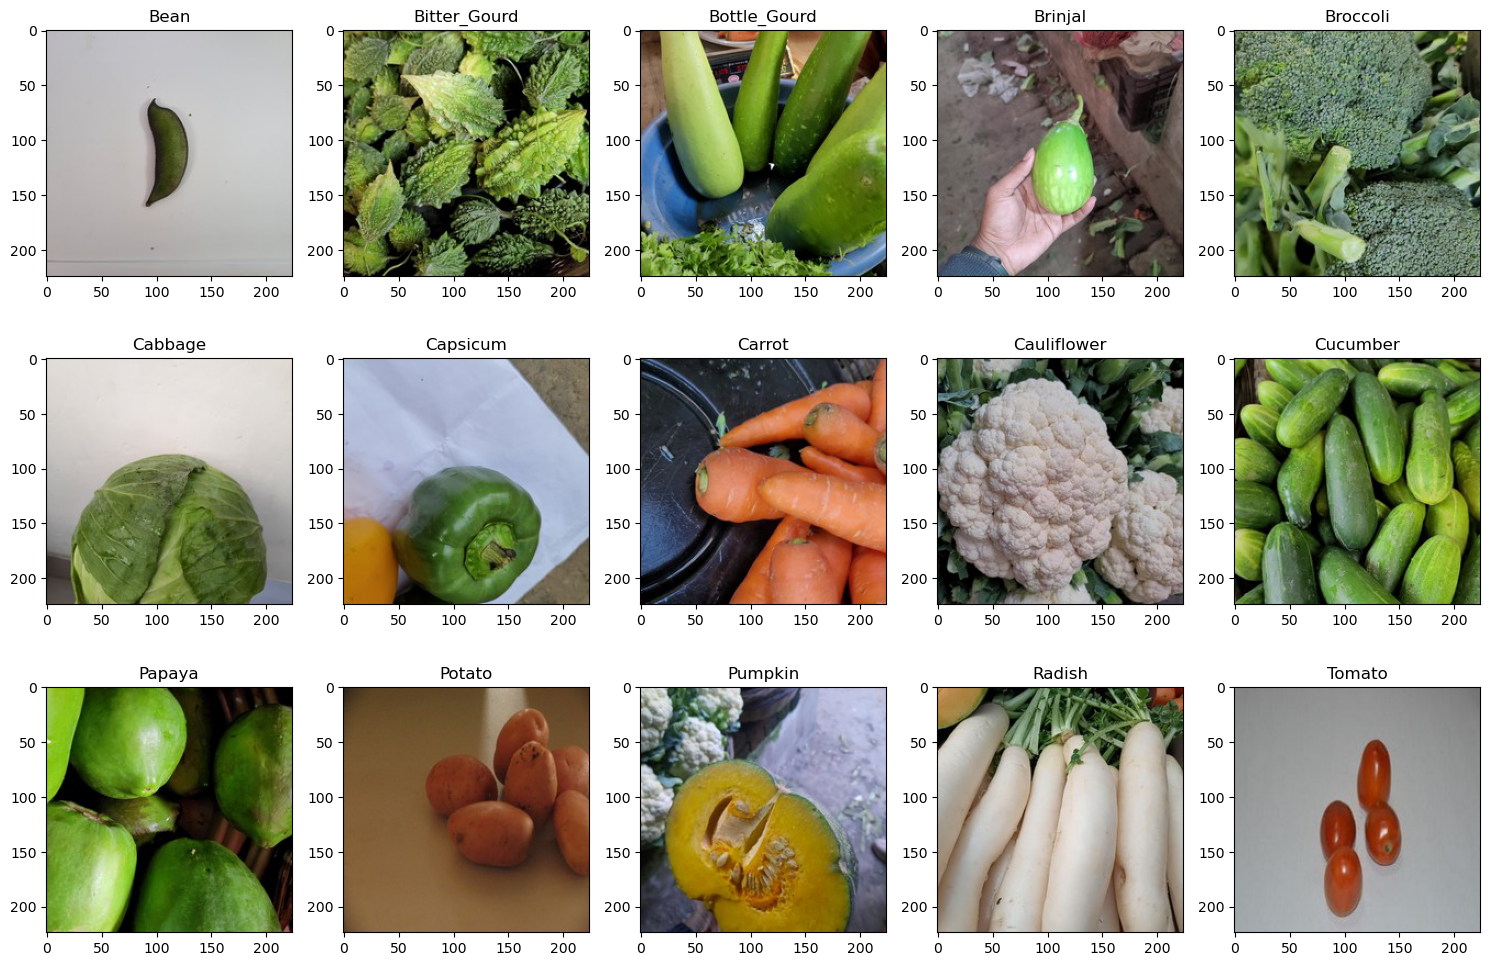

In [4]:
def plot_images(image_categories):
    
    
    plt.figure(1, figsize=(15, 10))
    for i, cat in enumerate(image_categories):
        
        
        image_path = train_path + '/' + cat
        images_in_folder = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255
        # Creating Subplot and plot the images
        plt.subplot(3, 5, i+1)
        plt.title(cat)
        plt.imshow(img_arr)
        
    plt.tight_layout()

plot_images(image_categories)

In [5]:
# checking if the dataset is balanced or imbalanced

def count_samples_per_category(dataset_path):
   
    categories = os.listdir(dataset_path)
    sample_counts = {}
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            num_samples = len(os.listdir(category_path))
            sample_counts[category] = num_samples
    return sample_counts

def is_balanced(dataset_path):
    
    sample_counts = count_samples_per_category(dataset_path)
    min_samples = min(sample_counts.values())
    max_samples = max(sample_counts.values())
    balance_threshold = 1.0
    if min_samples / max_samples >= balance_threshold:
        return True
    else:
        return False


dataset_path = r"C:\Users\Afrin\Downloads\vegetable dataset"

balanced = is_balanced(dataset_path)
if balanced:
    print("The dataset is balanced.")
else:
    print("The dataset is not balanced.")
    
# Counting the number of data points per category
category_counts = count_samples_per_category(dataset_path)

# Printing the number of data points per category
print("Number of data points per category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

# Calculating the total number of data points in the dataset
total_samples = sum(category_counts.values())

# Printing the total number of data points in the dataset
print("\nTotal number of data points in the dataset:", total_samples)


The dataset is balanced.
Number of data points per category:
test: 15
train: 15
validation: 15

Total number of data points in the dataset: 45


<Axes: >

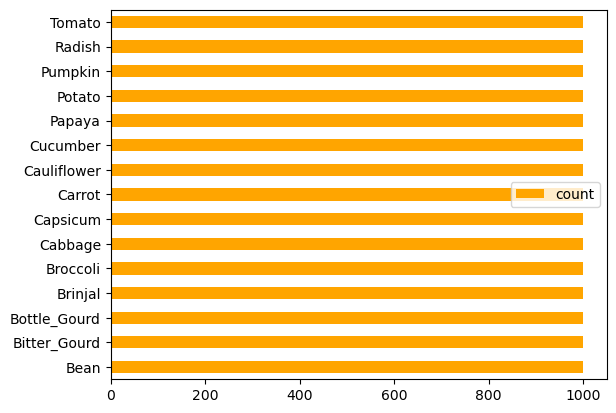

In [6]:
# plot

images_length={}
for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        images_length[cat]=len(images_in_folder)
        
pd.DataFrame(images_length,index = ['count']).T.plot(kind='barh',color='orange')

In [7]:
#  setting up data generators for training, validation, and testing

In [8]:
print("Train Data: ",end=' ')
train_gen = ImageDataGenerator(
                  rescale = 1./255,# Normalise the data
                  shear_range = 0.2,
                  zoom_range = 0.2,
                  horizontal_flip = True)

train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            )

print("Validation Data: ",end=' ')
val_gen = ImageDataGenerator(rescale=1./255) 
val_image_generator = val_gen.flow_from_directory(
                                            val_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            )
print("Test Data: ",end=' ')
test_gen = ImageDataGenerator(rescale=1./255)
test_image_generator = val_gen.flow_from_directory(
                                            val_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            shuffle = False
                                            )

Train Data:  Found 15000 images belonging to 15 classes.
Validation Data:  Found 3000 images belonging to 15 classes.
Test Data:  Found 3000 images belonging to 15 classes.


In [9]:
# converting class labels into interger classes by using "train_image_generator.class_indices" which is a dictionary
# provided by flow_from_directory method of imageGenerator class

In [10]:
class_map=dict([(v,k) for k,v in train_image_generator.class_indices.items()])

print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [11]:
# here we have got a dictionary of class labels converted into interger class

In [12]:
# model creation

In [13]:
input_layer = Input(shape=(224, 224, 3))

conv1 = Conv2D(64, kernel_size=(5, 5), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, kernel_size=(5, 5), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


flatten = Flatten()(pool2)


dense1 = Dense(1024, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)


output_layer = Dense(15, activation='softmax')(dense2)


In [14]:
model_le= Model(inputs=input_layer, outputs=output_layer)

In [15]:

model_le.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 220, 220, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 89888)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      92,046,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,235,567 (351.85 MB)

 Trainable params: 92,235,567 (351.85 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import tensorflow.keras.callbacks as callbacks

early_stopping = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Defining optimizer with learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_le.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model_le.fit(train_image_generator, epochs=30, verbose=1, 
                    validation_data=val_image_generator, 
                    steps_per_epoch=15000//64, 
                    validation_steps=3000//64, 
                    callbacks=[early_stopping]
                   )


Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1294s 5s/step - accuracy: 0.4045 - loss: 1.8470 - val_accuracy: 0.7130 - val_loss: 0.8943
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7188 - loss: 0.7590 - val_accuracy: 0.7857 - val_loss: 0.7696
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1291s 5s/step - accuracy: 0.7721 - loss: 0.7089 - val_accuracy: 0.8217 - val_loss: 0.5485
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8281 - loss: 0.5647 - val_accuracy: 0.8214 - val_loss: 0.5157
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1304s 6s/step - accuracy: 0.8644 - loss: 0.4386 - val_accuracy: 0.8971 - val_loss: 0.3438
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8750 - loss: 0.3011 - val_accuracy: 0.9107 - val_loss: 0.2228
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1323s 5s/step - accuracy: 0.9036 - loss: 0.3248 - val_accuracy: 0.9022 - val_loss: 0.3132
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8750 - loss: 0.4201 - val_accu

In [17]:
# plotring accuracy vs validation accuracy

In [18]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy',color='green')
    plt.plot(history.history['val_accuracy'],label='validation accuracy',color='black',linestyle='dashed')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

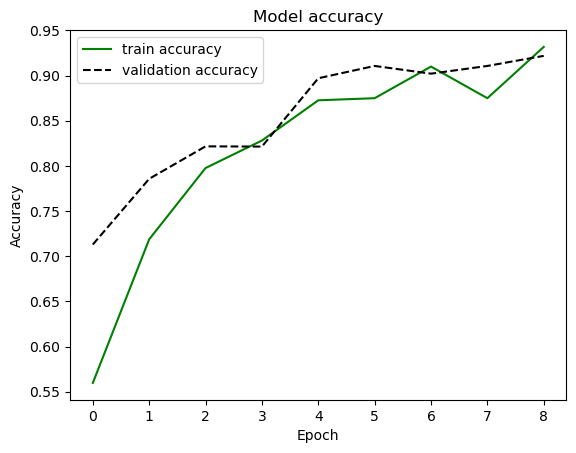

In [19]:
plot_accuracy(hist)

In [20]:
#  plotting loss vs validation loss

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss",color='red')
    plt.plot(history.history['val_loss'],label="validation loss",color='black',linestyle='dashed')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

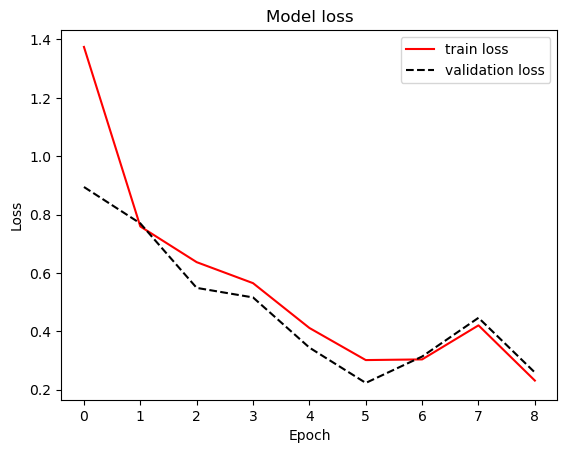

In [22]:
plot_loss(hist)

In [23]:
# Model Evaluation

In [24]:
def eval_(model):

    plt.figure(figsize=(20, 15))
    test_loss, test_acc =model.evaluate(test_image_generator)
    print(f'Model Test loss : {np.round(test_loss,2)} and Test Accuracy : {np.round(test_acc,2)} ')
    
    y_pred = model.predict(test_image_generator)
    predicted_classes = np.argmax(y_pred,axis=1)
    print("\n------- Classification Report -------\n",classification_report(test_image_generator.classes,predicted_classes))
    
    # Confusion Matrix dispaly
    ConfusionMatrixDisplay(confusion_matrix(test_image_generator.classes,predicted_classes),display_labels = test_image_generator.class_indices.keys()).plot()
    plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8741 - loss: 0.3724
Model Test loss : 0.34 and Test Accuracy : 0.89 
47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       0.89      0.77      0.83       200
           1       0.80      0.96      0.87       200
           2       0.89      0.89      0.89       200
           3       0.87      0.83      0.85       200
           4       0.86      0.95      0.90       200
           5       0.93      0.83      0.88       200
           6       0.98      0.89      0.93       200
           7       0.93      0.99      0.96       200
           8       0.85      0.90      0.88       200
           9       0.81      0.90      0.86       200
          10       0.95      0.83      0.89       200
          11       0.98      0.93      0.96       200
          12       0.87      0.89      0.88       200
          13       0.91      0.95      0.9

<Figure size 2000x1500 with 0 Axes>

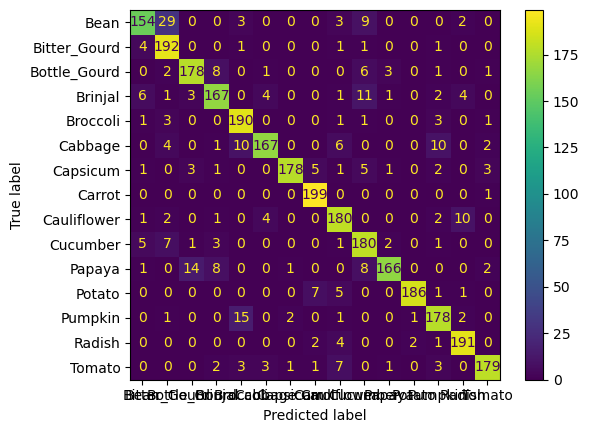

In [25]:
eval_(model_le)

In [26]:
# Applying Transfer learning on to the model

In [27]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=[224,224,3])

# Frezzing all the layers which prevents the weights being updated
for layer in base_model.layers:
    layer.trainable = False

## Add new layers to the Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(15, activation='softmax')(x)


model_V3 = Model(inputs=base_model.input, outputs=prediction)

early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True,min_delta=0.1)

## compile the model
model_V3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

##fit the model
hist = model_V3.fit(train_image_generator, epochs=30, verbose=1, 
                    validation_data=val_image_generator, 
                    steps_per_epoch=15000//64, 
                    validation_steps=3000//64, 
                    callbacks=[early_stopping]
                   )

Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1196s 5s/step - accuracy: 0.8342 - loss: 0.5501 - val_accuracy: 0.9898 - val_loss: 0.0371
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9688 - loss: 0.1344 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1191s 5s/step - accuracy: 0.9777 - loss: 0.0755 - val_accuracy: 0.9891 - val_loss: 0.0378
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9688 - loss: 0.1010 - val_accuracy: 1.0000 - val_loss: 0.0453


In [28]:
# plotting loss and accuracy after applying transfer learning

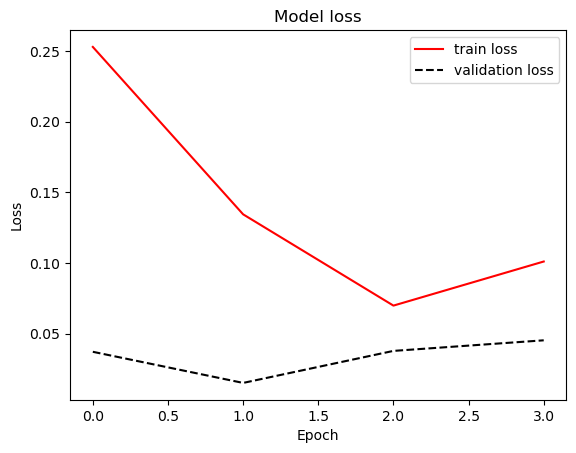

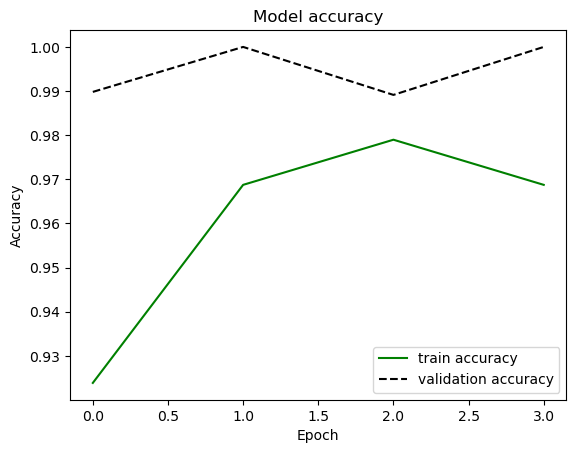

In [29]:
plot_loss(hist)
plot_accuracy(hist)

47/47 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.9892 - loss: 0.0385
Model Test loss : 0.04 and Test Accuracy : 0.99 
47/47 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.99      0.98      0.99       200
           2       0.99      0.97      0.98       200
           3       0.97      0.98      0.98       200
           4       1.00      1.00      1.00       200
           5       1.00      1.00      1.00       200
           6       1.00      0.99      0.99       200
           7       0.98      1.00      0.99       200
           8       0.99      1.00      0.99       200
           9       0.98      0.98      0.98       200
          10       0.98      0.96      0.97       200
          11       0.99      0.99      0.99       200
          12       0.99      0.98      0.99       200
          13       0.99      0.99      0

<Figure size 2000x1500 with 0 Axes>

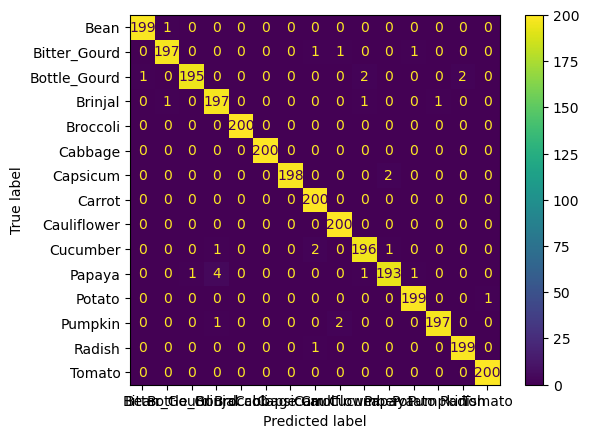

In [30]:
eval_(model_V3)


In [31]:
## Freezing only a Few layer

In [32]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))


# Frezzing all the layers which prevents the waits being updated
for layer in base_model.layers:
    layer.trainable = False
    
# unFrezzing last few layers 
for layer in base_model.layers[-10:]:
    layer.trainable = True

## Adding new layers to the Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(15, activation='softmax')(x)

In [33]:
model_v = Model(inputs=base_model.input, outputs=prediction)

In [34]:
early_stopping = keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',restore_best_weights=True) # Set up callbacks

## compile the model
model_v.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
##fit the model
hist = model_v.fit(train_image_generator, 
                 epochs=30, 
                 verbose=1, 
                 validation_data=val_image_generator, 
                 steps_per_epoch = 15000//64, 
                 validation_steps = 3000//64, 
                 callbacks=early_stopping,
                 )

Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 2211s 9s/step - accuracy: 0.5723 - loss: 1.4923 - val_accuracy: 0.9528 - val_loss: 0.2026
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9375 - loss: 0.1748 - val_accuracy: 1.0000 - val_loss: 0.1070
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1179s 5s/step - accuracy: 0.9406 - loss: 0.2378 - val_accuracy: 0.9759 - val_loss: 0.1062
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9531 - loss: 0.1973 - val_accuracy: 0.9643 - val_loss: 0.1654
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1181s 5s/step - accuracy: 0.9612 - loss: 0.1574 - val_accuracy: 0.9871 - val_loss: 0.0728
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9531 - loss: 0.1478 - val_accuracy: 1.0000 - val_loss: 0.0261
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1174s 5s/step - accuracy: 0.9733 - loss: 0.1069 - val_accuracy: 0.9891 - val_loss: 0.0555
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9844 - loss: 0.0830 - val_

In [36]:
# plotting loss and accuracy plots after freezing only few layers

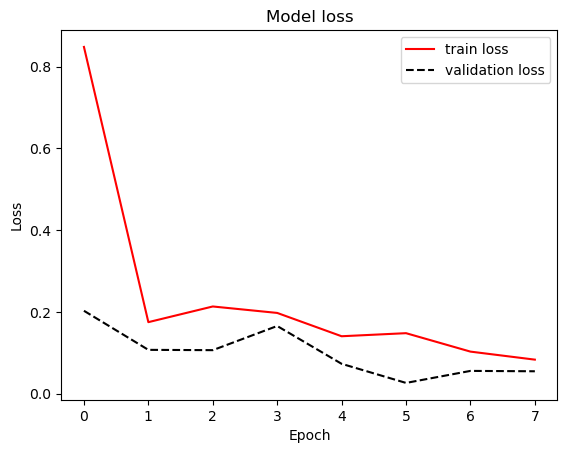

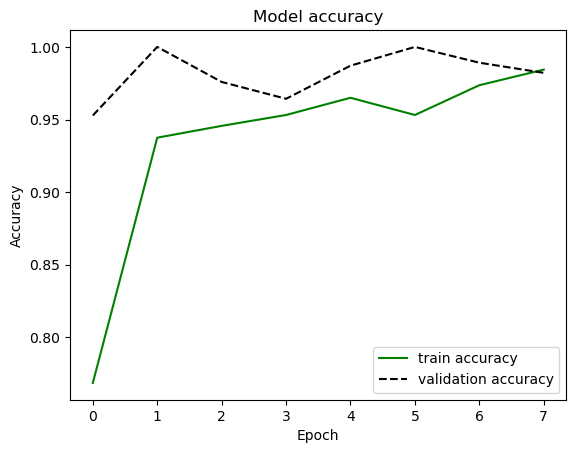

In [37]:
plot_loss(hist)
plot_accuracy(hist)

47/47 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.9861 - loss: 0.0733
Model Test loss : 0.07 and Test Accuracy : 0.99 
47/47 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.99      0.98      0.99       200
           2       0.99      0.98      0.99       200
           3       0.96      0.97      0.97       200
           4       1.00      1.00      1.00       200
           5       1.00      1.00      1.00       200
           6       1.00      1.00      1.00       200
           7       0.98      0.99      0.99       200
           8       0.99      1.00      1.00       200
           9       0.97      0.96      0.97       200
          10       0.97      0.95      0.96       200
          11       0.98      0.99      0.99       200
          12       1.00      0.98      0.99       200
          13       0.99      0.99      0

<Figure size 2000x1500 with 0 Axes>

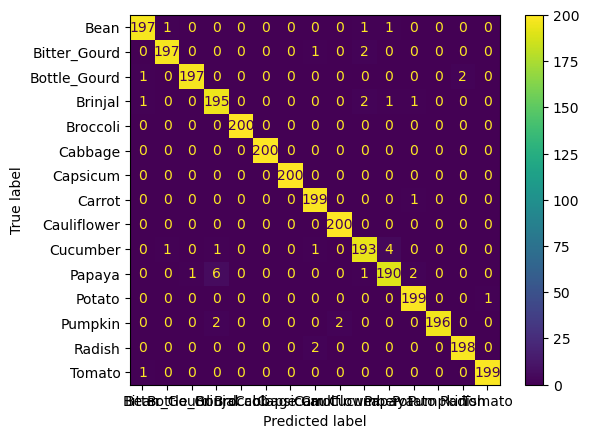

In [38]:
eval_(model_v)

In [39]:
# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


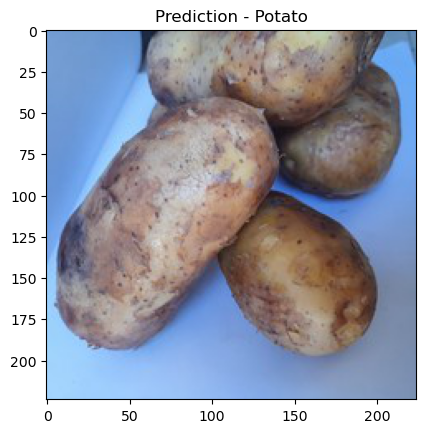

In [40]:
def predict(label,image_number):

    if label not in class_map.values() or image_number >=1000:
        print('Wrong Input 1. check if label in those 15 classes 2. image_number must be less than 1000')
    image_path = train_path + '/' + label
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[image_number]
    image_path += '/'+first_image_of_folder
    
    img_ = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model_v.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(class_map[index]))
    plt.imshow(img_array)
    

predict('Potato',179)  